<a href="https://colab.research.google.com/github/Rahul-15/object_detection/blob/master/updated_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q pydrive

    100% |████████████████████████████████| 993kB 20.1MB/s 


In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131284 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force

Enter verification code: ··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/

Files in Drive:
 2f80aa05-916b-4db1-b9b7-13f99efe8ee3.enc  'HAR by DVS.png'
 ak-1.pdf				   'Human Activity Recognition.pdf'
'ak fee receipt.pdf'			    img009.jpg
 bycycle.jpeg				   'Optimisation application.odt'
 car.jpg				    projectGit.odt
'classification process.jpg'		    projects
'Colab Notebooks'			    resume
'computer-system-architecture mano.pdf'     test.jpg
'consent letter.37_2'			   'training process.jpg'
 cycle.jpeg				    week3
 Documents				   'Your big idea.pdf'


In [6]:
!cd drive/week3
!ls drive/week3

1506.02640.pdf						   model_data
1612.08242.pdf						   README.md
Autonomous+driving+application+-+Car+detection+-+v1.ipynb  yad2k
Drive.ai+Dataset+Sample+LICENSE				   yolo.cfg
font							   yolo_utils.py
LICENSE


In [7]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving yolo_utils.py to yolo_utils.py
User uploaded file "yolo_utils.py" with length 3231 bytes


In [8]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving __init__.py to __init__.py
Saving utils.py to utils.py


In [9]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving keras_darknet19.py to keras_darknet19.py
Saving keras_yolo.py to keras_yolo.py
User uploaded file "keras_darknet19.py" with length 2386 bytes
User uploaded file "keras_yolo.py" with length 16611 bytes


In [10]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


In [0]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    box_scores = np.multiply(box_confidence, box_class_probs)
   
    
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

In [0]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1)*(yi2 - yi1)
    box1_area = (box1[3] - box1[1])*(box1[2]- box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area
    iou = inter_area / union_area
    
    return iou

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    
    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    
    return scores, boxes, classes

In [0]:
sess = K.get_session()

In [0]:
class_names = read_classes("drive/week3/model_data/coco_classes.txt")
anchors = read_anchors("drive/week3/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

In [21]:
yolo_model = load_model("drive/week3/model_data/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [22]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [0]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [0]:
import colorsys
import imghdr
import os
import random
from keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont
def draw_boxes_temp(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='drive/week3/font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [0]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    image, image_data = preprocess_image("drive/" + image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes_temp(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("drive", image_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("drive", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 2 boxes for test.jpg
car 0.74 (357, 295) (746, 655)
car 0.78 (942, 327) (1280, 694)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


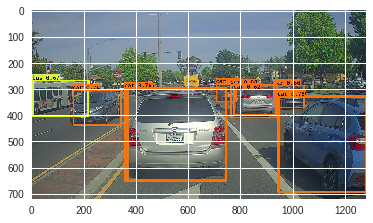

In [27]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 1 boxes for cycle.jpeg
bicycle 0.72 (210, 55) (268, 188)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


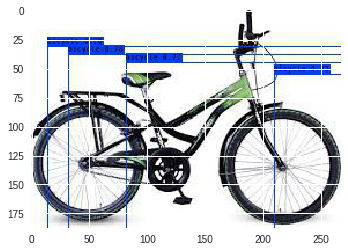

In [28]:
out_scores, out_boxes, out_classes = predict(sess, "cycle.jpeg")

Found 2 boxes for bycycle.jpeg
person 0.83 (280, 249) (260, 194)
bicycle 0.87 (101, 458) (260, 194)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


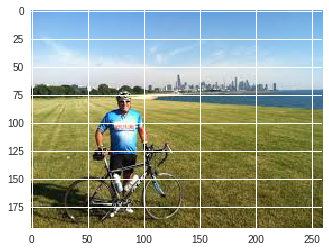

In [29]:
out_scores, out_boxes, out_classes = predict(sess, "bycycle.jpeg")

In [0]:
objects = []
with open("drive/week3/model_data/coco_classes.txt","r") as f:
  objects = f.readlines()

In [35]:
objects

['person\n',
 'bicycle\n',
 'car\n',
 'motorbike\n',
 'aeroplane\n',
 'bus\n',
 'train\n',
 'truck\n',
 'boat\n',
 'traffic light\n',
 'fire hydrant\n',
 'stop sign\n',
 'parking meter\n',
 'bench\n',
 'bird\n',
 'cat\n',
 'dog\n',
 'horse\n',
 'sheep\n',
 'cow\n',
 'elephant\n',
 'bear\n',
 'zebra\n',
 'giraffe\n',
 'backpack\n',
 'umbrella\n',
 'handbag\n',
 'tie\n',
 'suitcase\n',
 'frisbee\n',
 'skis\n',
 'snowboard\n',
 'sports ball\n',
 'kite\n',
 'baseball bat\n',
 'baseball glove\n',
 'skateboard\n',
 'surfboard\n',
 'tennis racket\n',
 'bottle\n',
 'wine glass\n',
 'cup\n',
 'fork\n',
 'knife\n',
 'spoon\n',
 'bowl\n',
 'banana\n',
 'apple\n',
 'sandwich\n',
 'orange\n',
 'broccoli\n',
 'carrot\n',
 'hot dog\n',
 'pizza\n',
 'donut\n',
 'cake\n',
 'chair\n',
 'sofa\n',
 'pottedplant\n',
 'bed\n',
 'diningtable\n',
 'toilet\n',
 'tvmonitor\n',
 'laptop\n',
 'mouse\n',
 'remote\n',
 'keyboard\n',
 'cell phone\n',
 'microwave\n',
 'oven\n',
 'toaster\n',
 'sink\n',
 'refrigerator

In [37]:
print(out_classes)

[1 0]


In [39]:
print(out_boxes)

[[457.993    101.067215 704.6083   682.8114  ]
 [249.08847  280.3317   644.88666  512.88385 ]]


Found 2 boxes for car2.jpg
person 0.63 (730, 243) (815, 301)
car 0.69 (342, 198) (1059, 582)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


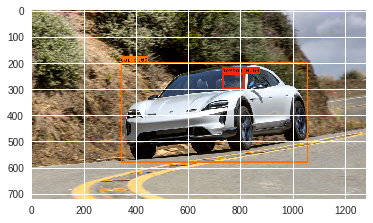

In [50]:
out_scores, out_boxes, out_classes = predict(sess, "car2.jpg")

In [51]:
out_boxes


array([[ 197.58562,  341.597  ,  581.8433 , 1058.6652 ],
       [ 243.15343,  730.197  ,  301.14957,  815.30286]], dtype=float32)

In [0]:
objects_name= ""
if(max(out_boxes[:,2])<360):
  objects_name = "no objects ahead,Route clear"
else:
  i,j = np.where(out_boxes==max(out_boxes[:,2]))
  objects_name = objects[out_classes[i[0]]][:-1]


In [79]:

objects_name

'car'

In [80]:
!pip install gTTS

  Stored in directory: /root/.cache/pip/wheels/ac/d3/52/db6c154b20dfaab7e0b514eb5eef92cecd057e40e16fdda58b
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gTTS gtts-token


In [81]:
from gtts import gTTS
text = objects_name
language='en'
myob=gTTS(text=text,lang=language,slow=False)
myob.save('Voice1.mp3')
import IPython.display as ipd
ipd.Audio(filename='Voice1.mp3',autoplay = True)